##### TP integrador
Download Dataset here:
[Buenos Aires public bike system](https://www.kaggle.com/datasets/fgarciablanco/buenos-aires-public-bike-system-dataset?resource=download)



In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import HTML
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from scipy.optimize import curve_fit
import statsmodels.api as sm



In [2]:
HTML('<a href="https://www.kaggle.com/datasets/fgarciablanco/buenos-aires-public-bike-system-dataset?resource=download" target="_blank">Download Dataset</a>')

In [3]:
df = pd.read_csv('./Datasets/recorridos-realizados-2018.csv', encoding='latin-1')
len(df)

1457509

In [5]:
df.head(5)
#df.info()

,bici_id_usuario,bici_Fecha_hora_retiro,bici_tiempo_uso,bici_nombre_estacion_origen,bici_estacion_origen,bici_nombre_estacion_destino,bici_estacion_destino,bici_sexo,bici_edad,bici_direccion,bici_pais
0,15728,26/05/2018 15:32:07,0:08:52,F. J. Santamaría de Oro,125,Acuña de Figueroa,54,M,28.0,TTE BENJAMIN MATIENZO,Argentina
1,26531,26/05/2018 3:42:41,0:30:49,Yatay,121,Hospital Garrahan,107,M,26.0,LAVALLE,Argentina
2,161323,26/05/2018 18:52:19,0:12:00,Aime Paine,151,Retiro II,130,M,44.0,olga cossettini,NaN
3,239148,26/05/2018 13:19:34,1:26:30,Galerías Pacífico,34,Juana Manso,26,M,36.0,larrea,NaN
4,260323,26/05/2018 8:41:53,0:11:29,Virrey Cevallos,183,Corrientes,132,M,26.0,chacabuco,NaN


In [7]:
# Convertir fecha_hora_retiro a datetime

df.bici_Fecha_hora_retiro = df.bici_Fecha_hora_retiro.apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))
df['date'] = df.bici_Fecha_hora_retiro.apply(lambda x: x.replace(minute=0, second=0))


Text(0.5, 1.0, 'Alquiler de bicis Julio 2016 - Julio 2018')

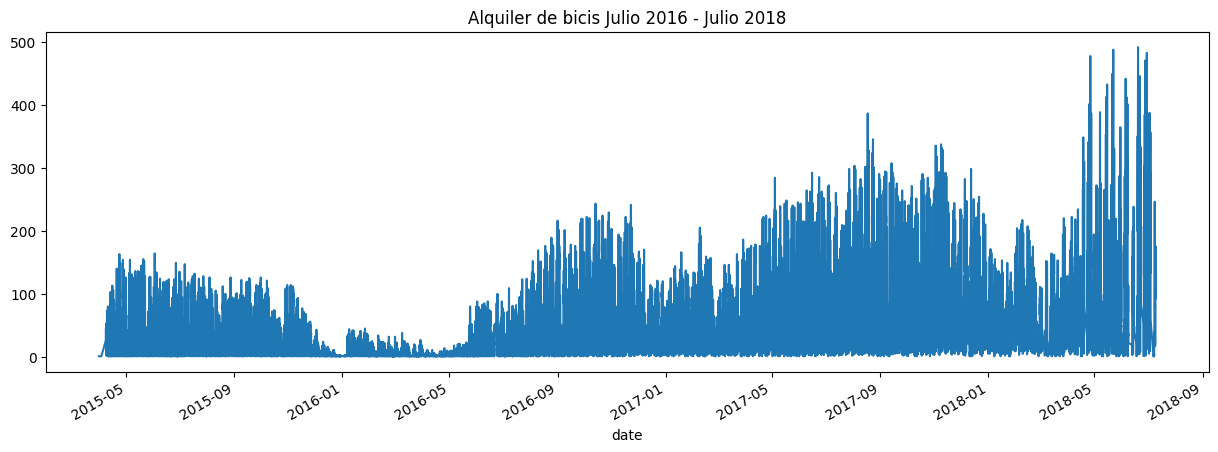

In [8]:
plt.figure(figsize=(15,5))
df.groupby('date').bici_id_usuario.count().plot()
plt.title('Alquiler de bicis Julio 2016 - Julio 2018')

#### Limpieza de datos

Observamos que hay muchos menos registros durante los primeros meses de 2016. Es por esta razón que tomaremos la decisión de achicar la serie y quedarnos con dos años de datos, desde Julio 2016 a Julio 2018.

In [205]:
fecha_limite = pd.to_datetime('2016-08-01 00:00:00')
df_shorten = df[df['date'] >= fecha_limite].copy()
bicis_por_dia = df_shorten.groupby('date').bici_id_usuario.count()

Text(0.5, 1.0, 'Alquiler de bicis Agosto 2016 - Julio 2018')

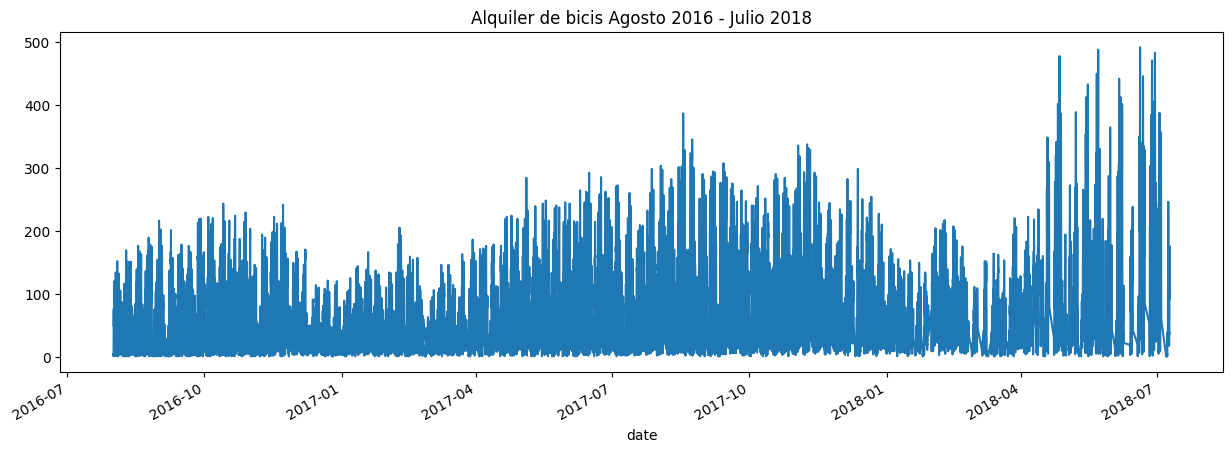

In [206]:
plt.figure(figsize=(15,5))
df_shorten.groupby('date').bici_id_usuario.count().plot()
plt.title('Alquiler de bicis Agosto 2016 - Julio 2018')

In [11]:
# Obtengo minutos de alquiler de bici

parse_duration = lambda duration_str: timedelta(
    hours=int(duration_str.split(':')[0]),
    minutes=int(duration_str.split(':')[1]) if len(duration_str.split(':')) >=2 else 0,
    seconds=int(duration_str.split(':')[2]) if len(duration_str.split(':')) >=3 else 0
)

df_shorten['bici_tiempo_uso_delta'] = df_shorten['bici_tiempo_uso'].apply(lambda x: parse_duration(x))
df_shorten['total_minutes'] = df_shorten['bici_tiempo_uso_delta'].dt.total_seconds() / 60

In [12]:
min(df_shorten.total_minutes), max(df_shorten.total_minutes)

(8.0, 1756.9166666666667)

Text(0.5, 1.0, 'Boxplot: duración de alquiler de bici (excluyendo outliers)')

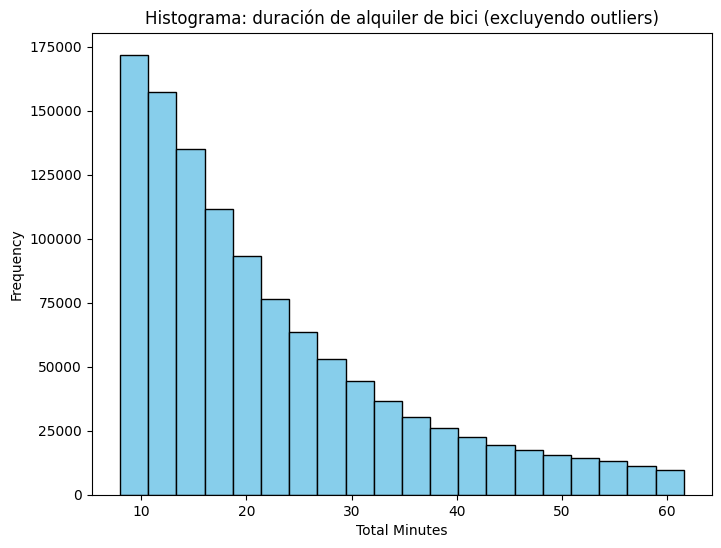

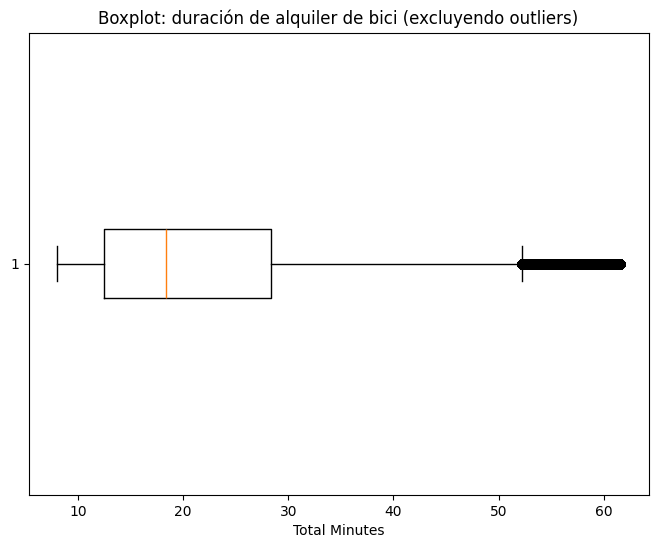

In [13]:
# Calculo quantiles
Q1 = df_shorten['total_minutes'].quantile(0.25)
Q3 = df_shorten['total_minutes'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtramos outliers
filtered_df = df_shorten[(df_shorten['total_minutes'] >= lower_bound) & (df_shorten['total_minutes'] <= upper_bound)]

plt.figure(figsize=(8, 6))
plt.hist(filtered_df['total_minutes'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Total Minutes')
plt.ylabel('Frequency')
plt.title('Histograma: duración de alquiler de bici (excluyendo outliers)')

plt.figure(figsize=(8, 6))
plt.boxplot(filtered_df['total_minutes'], vert=False)
plt.xlabel('Total Minutes')
plt.title('Boxplot: duración de alquiler de bici (excluyendo outliers)')


#### Observación
A partir del histograma observamos que la gran mayoría de los usuarios alquilan las bicicletas por períodos cortos menores a una hora. La mediana de uso está alrededor de los 20 minutos. 

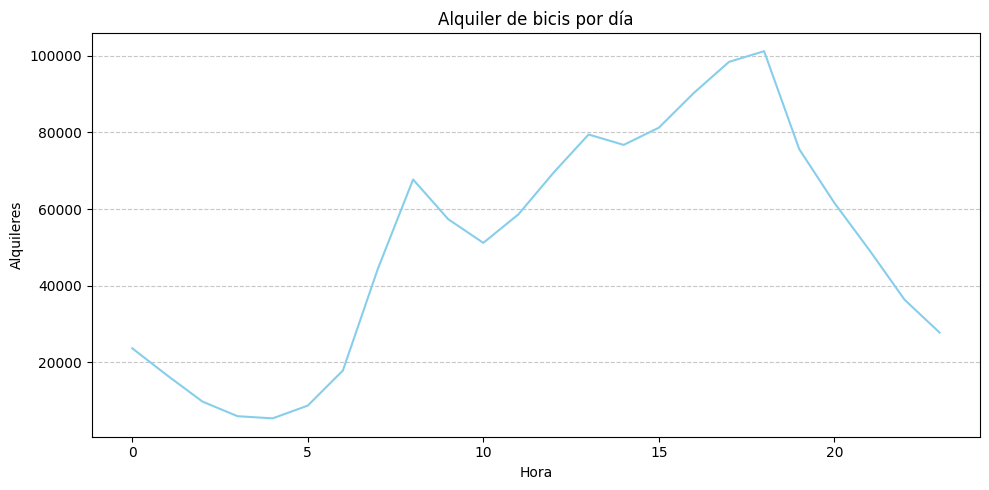

In [14]:
df_shorten['hour'] = df_shorten['date'].dt.hour
hourly_rentals = df_shorten.groupby('hour')['bici_id_usuario'].count()

plt.figure(figsize=(10, 5))
hourly_rentals.plot( color='skyblue')
plt.title('Alquiler de bicis por día')
plt.xlabel('Hora')
plt.ylabel('Alquileres')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


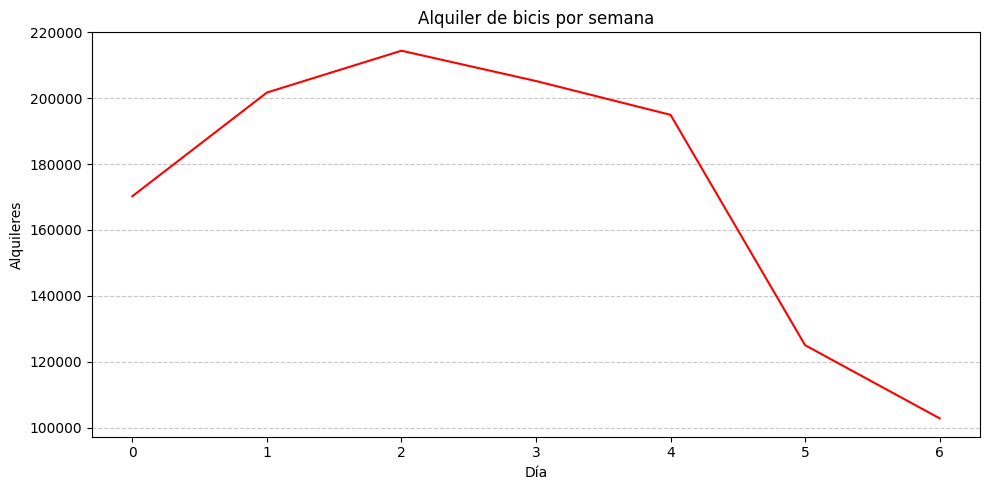

In [15]:
df_shorten['dia'] = df_shorten['date'].dt.weekday
weekly_rentals = df_shorten.groupby('dia')['bici_id_usuario'].count()

plt.figure(figsize=(10, 5))
weekly_rentals.plot( color='red')
plt.title('Alquiler de bicis por semana')
plt.xlabel('Día')
plt.ylabel('Alquileres')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Observación

De estos gráficos se desprende que:
* de lunes a viernes hay más alquileres de bicis que durante los fines de semana. 
* Por otro lado, hay tres picos de alquileres a las 9 am, al mediodía y alrededor de las 18, lo que coincide con los horarios en que la mayoría de la gente va y vuelve de trabajar.
* La serie presenta valles en las horas no pico, con una drástica caída durante la madrugada.

##### 1 mes vs 6 meses de datos

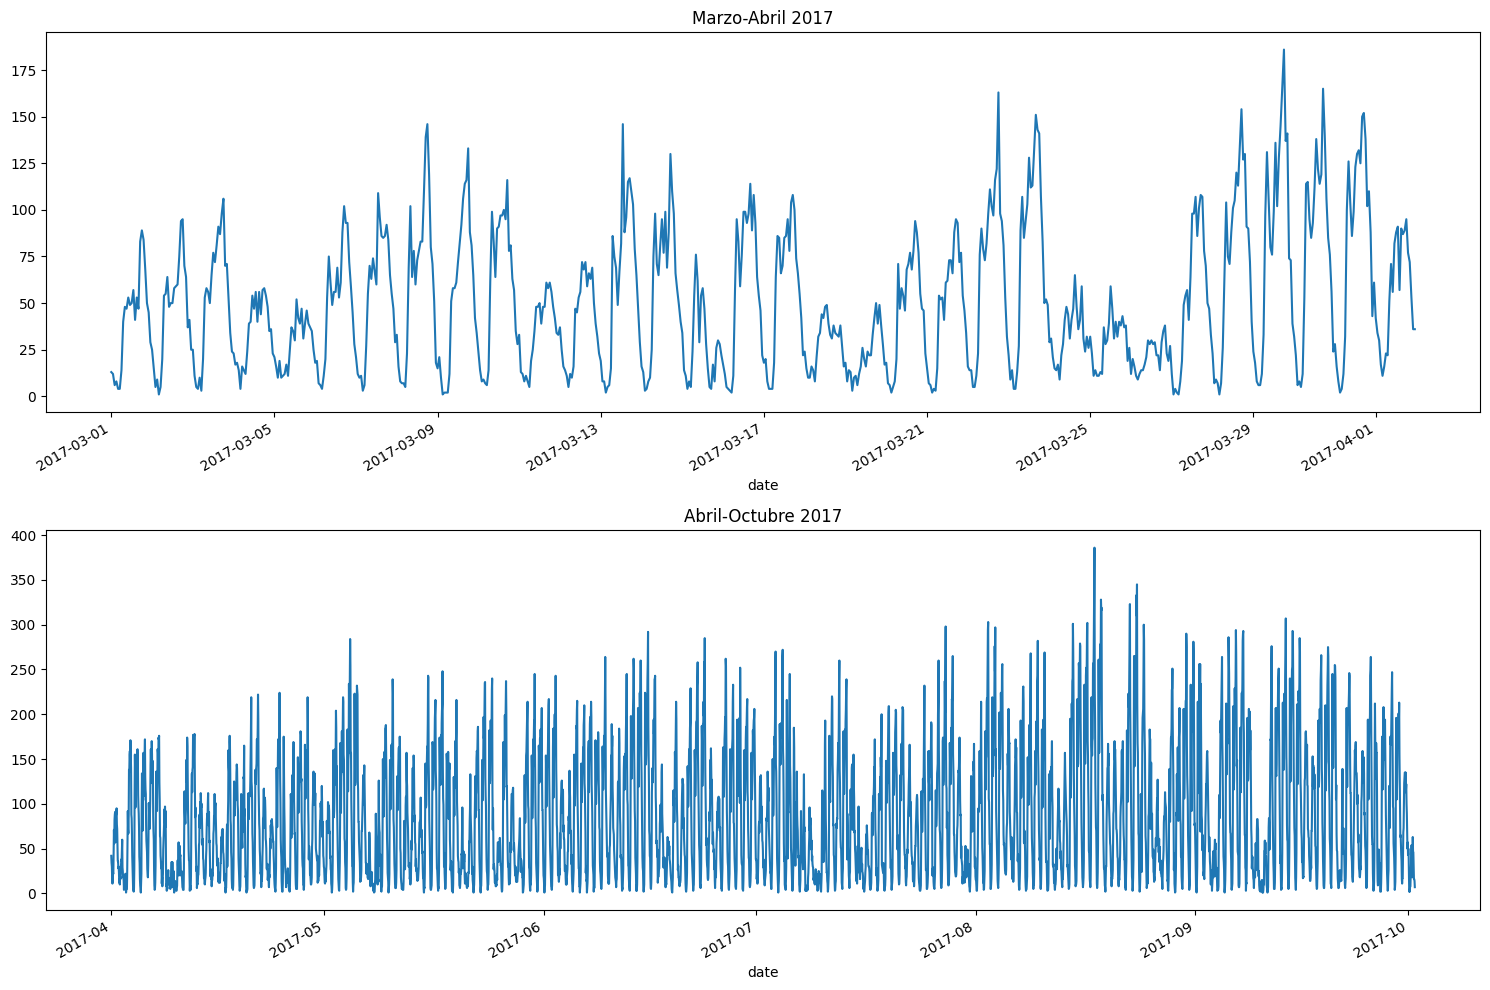

In [16]:
s = df.groupby('date').bici_id_usuario.count()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

## Visualización un mes de datos
s['2017-03-01': '2017-04-01'].plot(ax=axes[0])
axes[0].set_title('Marzo-Abril 2017')

# Visualización 6 meses de datos
s['2017-04-01': '2017-10-01'].plot(ax=axes[1])
axes[1].set_title('Abril-Octubre 2017')

plt.tight_layout()
plt.show()

#### Análisis
El dataset contiene información sobre el alquiler de bicicletas en la Ciudad de Buenos Aires durante el período Marzo 2015 - Julio 2018.

* En el gráfico de toda la serie se observa una tendencia creciente a partir del 2016 con dos valles marcados durante los meses de enero y febrero de 2017 y 2018 que coinciden con los meses donde la mayor cantidad de gente suele estar de vacaciones. 
La tendencia creciente podría deberse a un incremento en la adopción del servicio de alquiler de bicis.
* Se trata de una serie univariada y discreta 
* Graficamos también por día de la semana y por hora. Se observa cómo decae el alquiler durante los fines de semana y cómo la mayor cantidad de alquileres se da entre las 08 y las 20 horas, con un pico a las 18/19 horas. Esto coincide con el horario en que la gente entra y sale de trabajar. Mientras que el alquiler cae drásticamente durante las horas de la madrugada.
* Graficando un mes de datos podemos observar cierta estacionalidad dada por los picos y valles entre semanas. 
* Graficando seis meses de datos en el período de Abril 2017 - Octubre 2017 vemos que la estacionalidad se mantiene.

#### Modelo aditivo de cuatro componentes 
A partir de la cantidad de usuario por día

In [17]:
rents = df_shorten.set_index('date')
rents = rents.resample('D').bici_id_usuario.count()

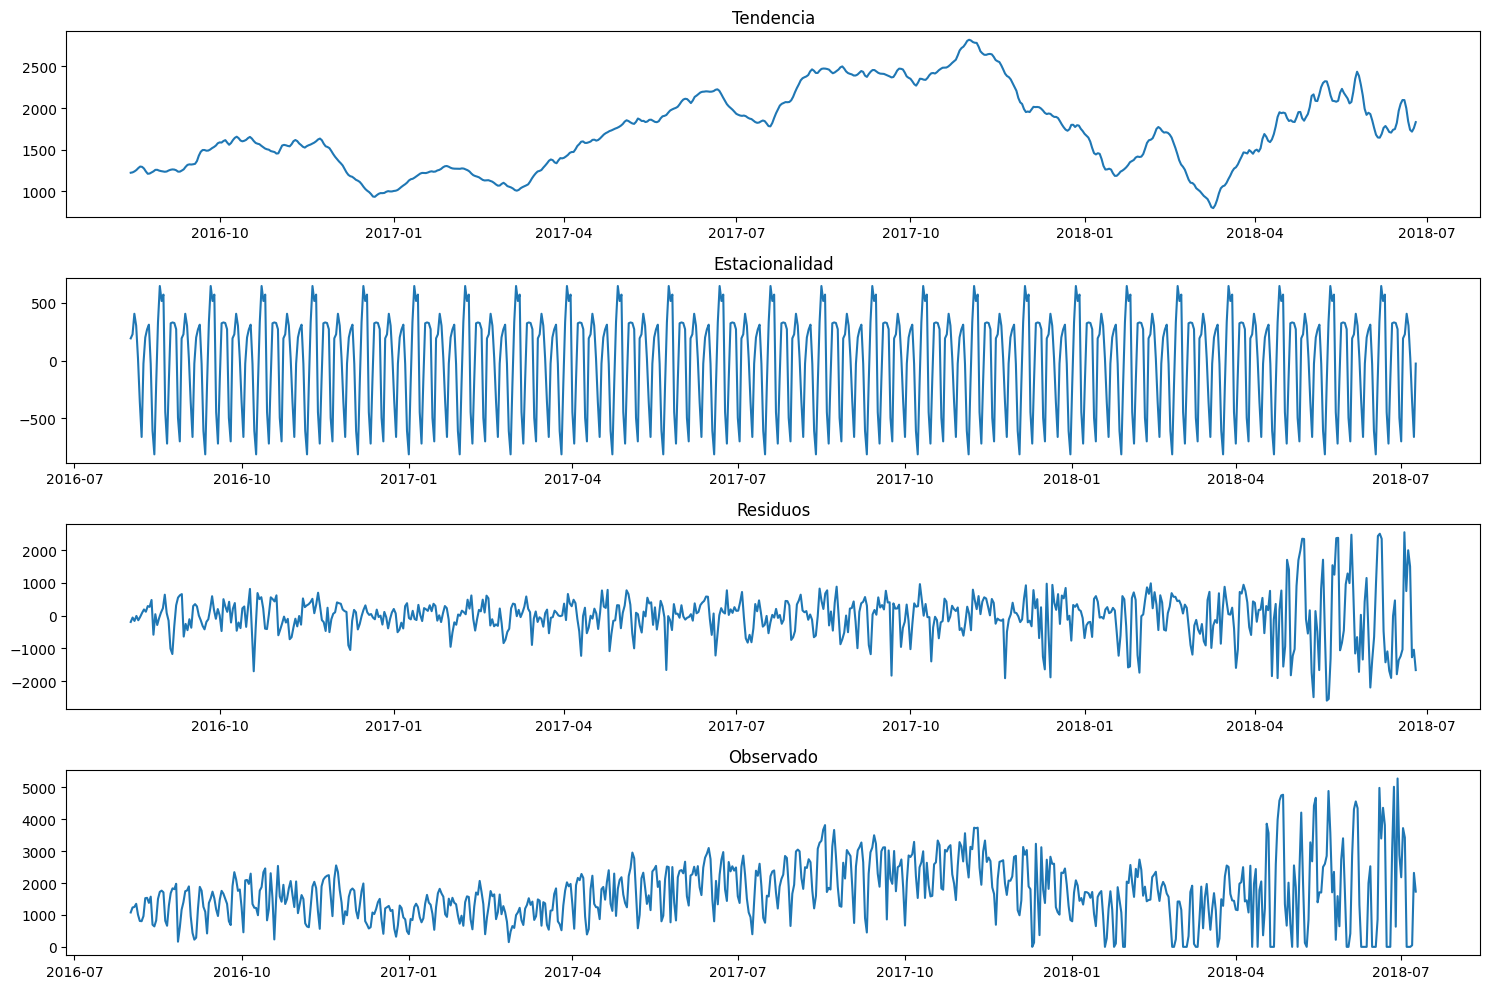

In [109]:
rents = df_shorten.set_index('date')
rents = rents.resample('D').bici_id_usuario.count()
daily_result = seasonal_decompose(rents, model='additive', period=28)

plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(daily_result.trend)
plt.title('Tendencia')

plt.subplot(4, 1, 2)
plt.plot(daily_result.seasonal)
plt.title('Estacionalidad')

plt.subplot(4, 1, 3)
plt.plot(daily_result.resid)
plt.title('Residuos')

plt.subplot(4, 1, 4)
plt.plot(daily_result.observed)
plt.title('Observado')

plt.tight_layout()
plt.show()

#### Análisis
* A partir de los gráficos podemos observar una tendencia creciente a partir de los meses de marzo y decreciente a partir de diciembre. 
* Observamos una clara estacionalidad en la serie que coincide con lo visto en los gráficos intrasemanales e intradiarios.
* No parece haber ningún patrón en el residual (observado - (trend+seasonality))

#### Tiempo de uso del servicio

In [19]:
# Nos quedamos con la mediana 

daily_rentals = df_shorten.groupby(pd.Grouper(key='date', freq='D'))['total_minutes'].median().reset_index()
daily_rentals = daily_rentals.set_index('date')
daily_rentals.isna().sum()

total_minutes    36
dtype: int64

In [20]:
daily_rentals = daily_rentals.dropna()
daily_rentals = daily_rentals[daily_rentals.total_minutes < 1000]

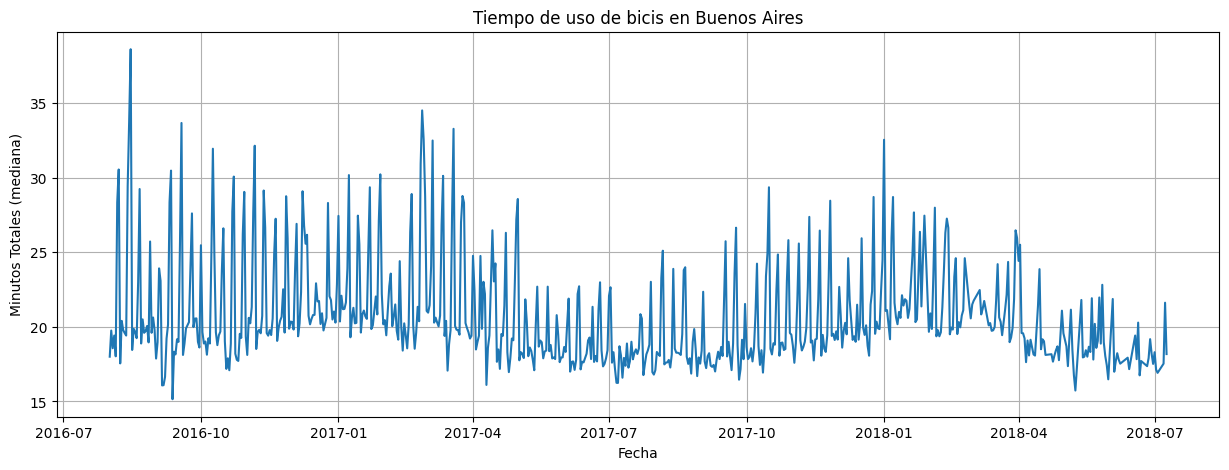

In [21]:
plt.figure(figsize=(15, 5))
plt.plot(daily_rentals.index, daily_rentals['total_minutes'])
plt.title('Tiempo de uso de bicis en Buenos Aires')
plt.xlabel('Fecha')
plt.ylabel('Minutos Totales (mediana)')
plt.grid(True)

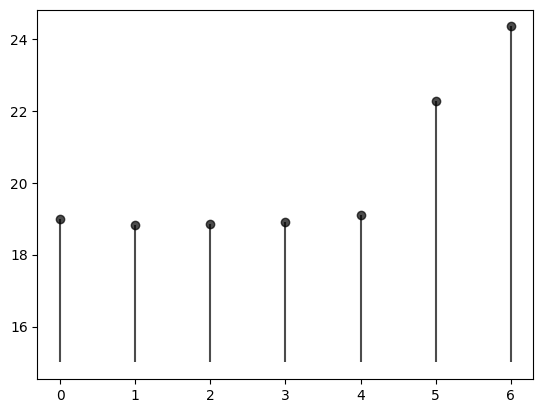

In [119]:
plt.vlines(weekly_minutes.index, [15]*len(weekly_minutes), weekly_minutes.values, color='k', alpha=0.7)
plt.scatter(weekly_minutes.index, weekly_minutes.values, color='k', alpha=0.7)

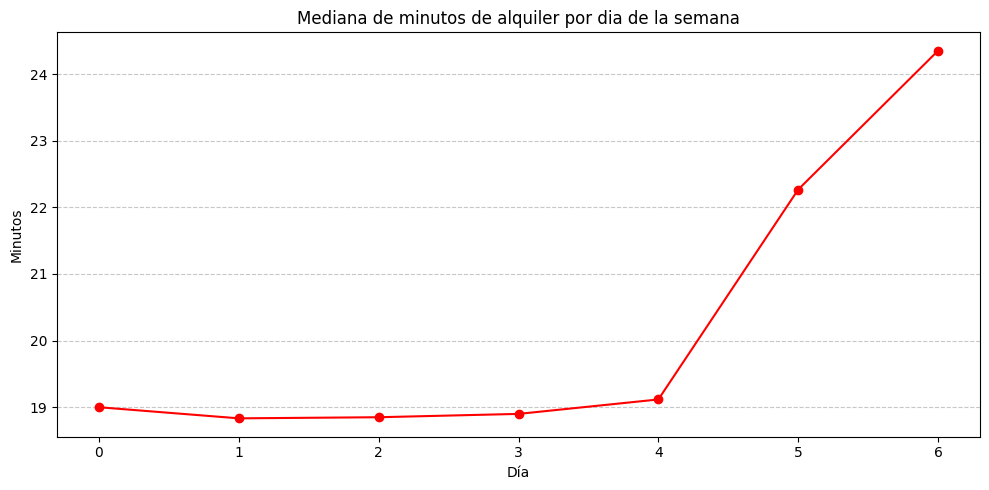

In [111]:
df_shorten['dia'] = df_shorten['date'].dt.weekday
weekly_minutes = df_shorten.groupby('dia')['total_minutes'].median()

plt.figure(figsize=(10, 5))
weekly_minutes.plot( color='red', marker="o")

plt.title('Mediana de minutos de alquiler por dia de la semana')
plt.xlabel('Día')
plt.ylabel('Minutos')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

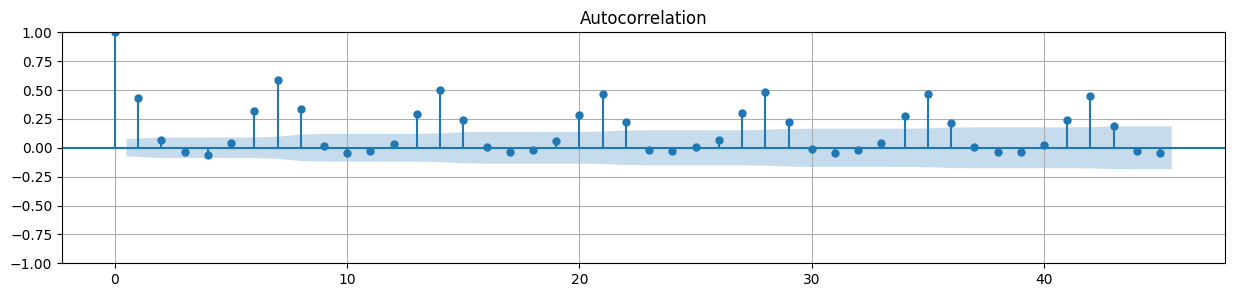

In [22]:
# Autocorrelacion

plt.figure(figsize=(15,3))
plot_acf(daily_rentals['total_minutes'], lags=45, ax=plt.gca())
plt.grid(True)
plt.show()

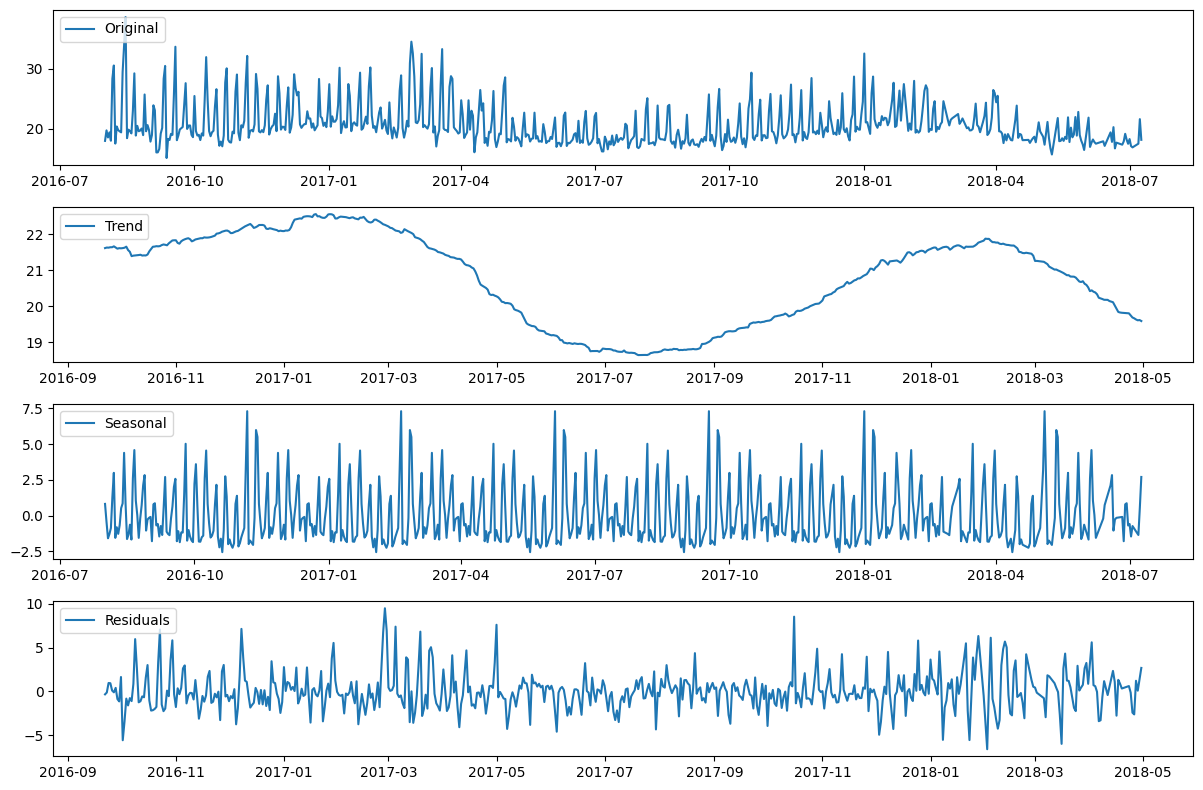

In [23]:
minutes_decompose = seasonal_decompose(daily_rentals['total_minutes'], model='additive', period=7*15)

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(daily_rentals['total_minutes'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(minutes_decompose.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(minutes_decompose.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(minutes_decompose.resid, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

#### Observación 

En estos gráficos podemos observar que:
* Hay una tendencia creciente en el tiempo de uso de la bicicleta a partir de noviembre, que coincide con los meses de verano. 
* Si bien, tal como vimos en los otros gráficos, cae el alquiler durante esos meses, al parecer los usuarios que usan las bicicletas lo hacen por períodos de tiempo más largos.
* Hay una tendencia decreciente durante los meses de invierno, esto es, los usuarios pasan menos tiempo arriba de la bicicleta. 

#### Extraer la tendencia y ajustar un modelo determinístico:
Explicar su relación con el contexto. Obtener conclusiones acerca de la validez del modelo.


In [24]:
# Extraemos tendencia calculada a partir de la cantidad de usuario por día (es decir NO tiempo de uso calculado en minutos)

tendencia = daily_result.trend

tendencia = tendencia.dropna()

x_data = np.arange(len(tendencia))
y_data = tendencia

#### Observación:
Como en el gráfico de la tendencia vemos períodos que presentan picos y valles, esto es varios minimos y máximos locales, decidimos fitear un modelo de coseno.
Los picos no necesariamente están a una distancia regular, pero sí vemos que la amplitud varía. 

A continuación definimos un modelo de **coseno**

In [25]:
# a = amplitud, b=frecuencia, c=fase, d=offset

def cosine_model(x, a, b, c, d):
    return a * np.cos(b * x + c) + d

In [26]:
''' Definimos los valores iniciales de los parámetros:
a (amplitud) = 0
b (frecuencia) = 2*np.pi/365
c (fase) = 0
d (offset) = np.mean(y_data)

'''

popt, pcov = curve_fit(cosine_model, x_data, y_data,  p0=(0, 2*np.pi/365, 0, np.mean(y_data)))
y_fit = cosine_model(x_data, *popt)

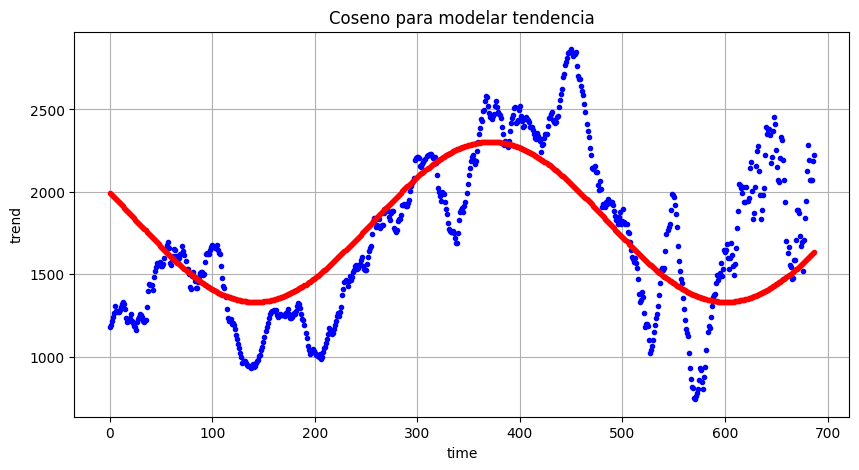

In [27]:
plt.figure(figsize=(10,5))
plt.plot(x_data, y_data, 'b.', label='original data')
plt.plot(x_data, y_fit, 'r.', label="fitted data")
plt.xlabel('time')
plt.ylabel('trend')
plt.title('Coseno para modelar tendencia')  
plt.grid(True)

Podemos ver que la curva no pasa por la media en todos los puntos y qua hay mucha varianza hacia el final de la serie. 
Podríamos probar con otra familia de modelos o bien probar con un modelo de coseno con más parámetros como haremos a continuación:
De este modo tendremos dos cosenos diferentes, cada uno con su propia amplitud, frecuencia y fase
intradiarios e intrasemanales. 


In [28]:
def double_cosine_model(x, a, b, c, d, e, f, g):
    """"Función para fitear un modelo coseno con 7 parámetros:
    a = amplitud
    b = frecuencia
    c = fase
    d = offset
    e = amplitud
    f = frecuencia
    g = fase
    """
    return a * np.cos(b * x + c) + d + e * np.cos(f * x + g)

In [29]:
popt, pcov = curve_fit(double_cosine_model, x_data, y_data, p0=(2500, 2*np.pi/365, 0, np.mean(y_data), 1, 2*np.pi/365*7, 0))
y_fit_double = double_cosine_model(x_data, *popt)


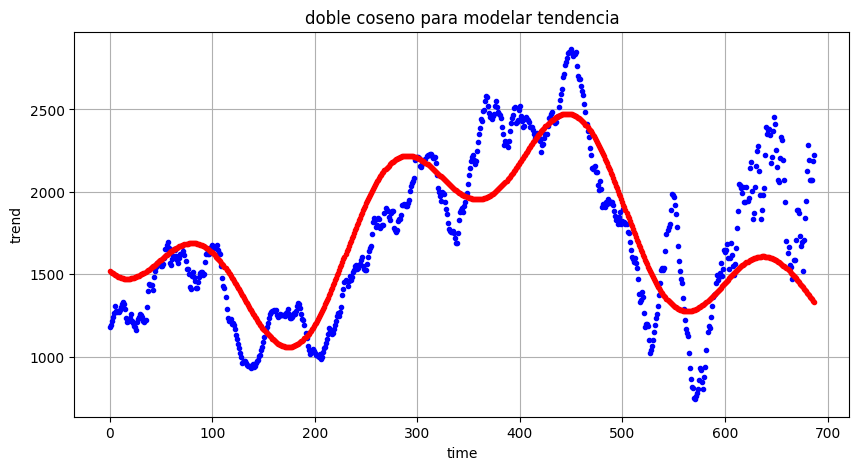

In [30]:
plt.figure(figsize=(10,5))
plt.plot(x_data, y_data, 'b.', label='original data')
plt.plot(x_data, y_fit_double, 'r.', label="fitted data")
plt.xlabel('time')
plt.ylabel('trend')
plt.title('doble coseno para modelar tendencia')  
plt.grid(True)

#### Realizamos una búsqueda de mejores hiperparámetros
Para cada combinación calculamos el RMSE

In [31]:
def rmse(x,y): return np.sqrt(((x-y)**2).mean())

best_rmse = None
best_sol = None

for i in range(1000):
    p0 = [np.random.randint(50, 5000), np.random.uniform(0.001, 0.5), np.random.random(), 
          np.random.randint(int(np.mean(y_data)/2),  int(np.mean(y_data)*2)), 
          np.random.randint(20, 1000), np.random.uniform(0.001, 0.75), np.random.random()]
    try:
        popt, pcov = curve_fit(double_cosine_model, x_data, y_data, p0=p0)
    except:
        continue

    y_fit = double_cosine_model(x_data, *popt)
    this_rmse = rmse(y_data, y_fit)
    if best_rmse is None or this_rmse < best_rmse:
        best_rmse = this_rmse
        best_sol = popt
        print("found better ", best_rmse)
    

found better  364.00378288540065
found better  361.66584961786856
found better  355.58530258096107
found better  352.17287135270703
found better  297.9780727894928
found better  297.97806996447224


#### Predecimos con los mejores hiperparámetros, es decir la combinación que nos da el menor rmse

In [32]:
y_fit_best= double_cosine_model(x_data, *best_sol)

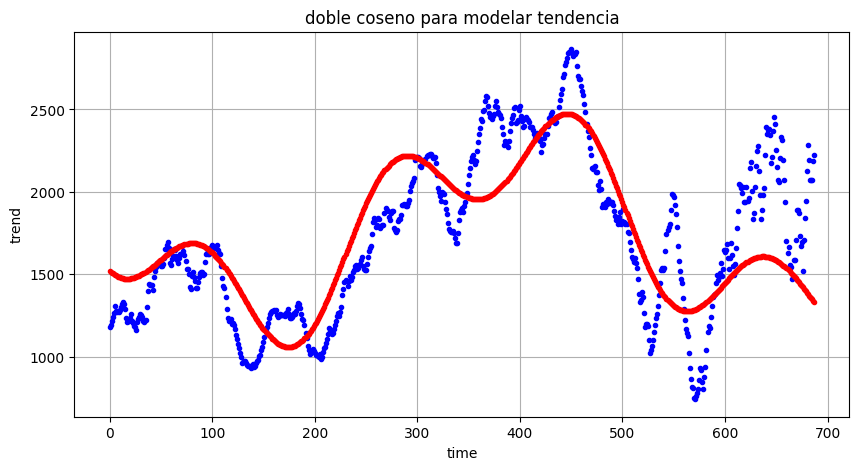

In [33]:
plt.figure(figsize=(10,5))
plt.plot(x_data, y_data, 'b.', label='original data')
plt.plot(x_data, y_fit_best, 'r.', label="fitted data")
plt.xlabel('time')
plt.ylabel('trend')
plt.title('doble coseno para modelar tendencia')  
plt.grid(True)

#### Evaluar si la serie es estacionaria

* Evaluar si la serie original es estacionaria.
* Aplicar transformaciones (preprocesamiento),
* graficar autocorrelación
* autocorrelación parcial
*  y extraer conclusiones.


In [34]:
bicis_por_dia.resample('D').sum()

date
2016-08-01    1077
2016-08-02    1233
2016-08-03    1249
2016-08-04    1348
2016-08-05    1008
              ... 
2018-07-05       0
2018-07-06       0
2018-07-07      50
2018-07-08    2317
2018-07-09    1730
Freq: D, Name: bici_id_usuario, Length: 708, dtype: int64

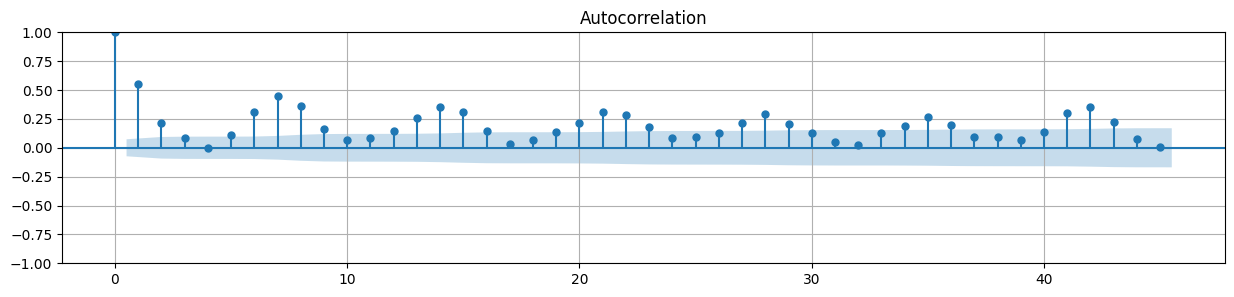

In [100]:
# calculamos  autocorrelación y autocorrelación parcial

plt.figure(figsize=(15,3))
plot_acf(bicis_por_dia.resample('D').sum(), lags=45, ax=plt.gca()) #lags=dias
plt.grid(True)
plt.show()

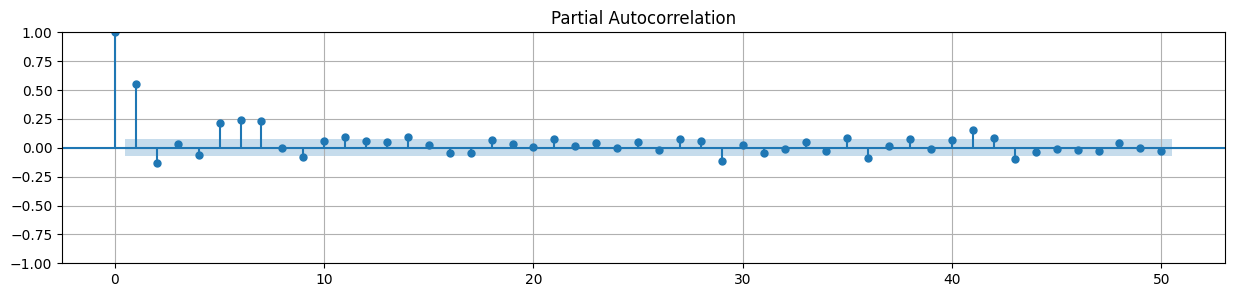

In [104]:
# autocorrelación parcial

from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(15,3))
plot_pacf(bicis_por_dia.resample('D').sum(), lags=50, ax=plt.gca()) #lags=dias
plt.grid(True)
plt.show()

A partir de este gráfico de autocorrelación, podemos observar una clara autocorrelación  intrasemanal,que coincide con lo observado en los gráficos más arriba, donde se ve la tendencia semanal (con más alquileres durante los días de semana). Se observan picos correspondientes a ciclos de 24 horas. 

In [127]:
nobs = len(bicis_por_dia)
12*(nobs/100)**0.25

42.65735046480134

In [135]:
adfuller

<function statsmodels.tsa.stattools.adfuller(x, maxlag: 'int | None' = None, regression='c', autolag='AIC', store=False, regresults=False)>

{'bodies': [<matplotlib.collections.PolyCollection at 0x139af3ed0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x139add190>,
 'cmins': <matplotlib.collections.LineCollection at 0x139af57d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x139572550>}

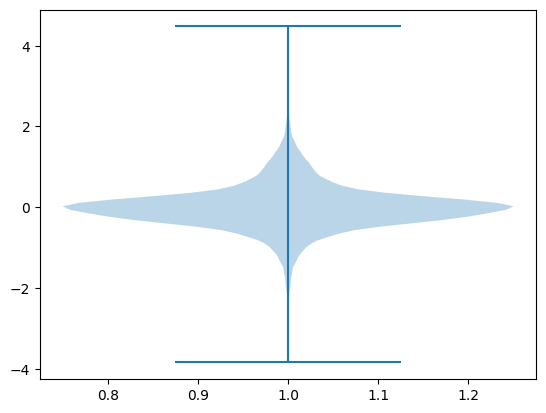

In [144]:
plt.violinplot(np.diff(np.log(bicis_por_dia)))

<Axes: xlabel='date'>

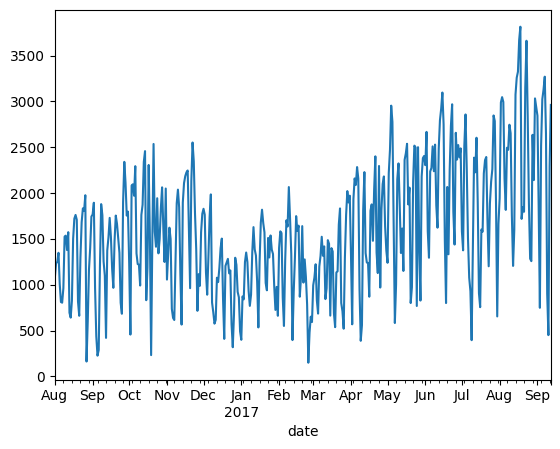

In [160]:
bicis_por_dia.resample('D').sum()[:-300].plot()

In [151]:
# aplicams test de dickey fuller

# adf_result = adfuller(np.diff(np.log(bicis_por_dia)))
# adf_result = adfuller(bicis_por_dia)
adf_result = adfuller(np.log(bicis_por_dia.resample('D').sum()+1 ))
print('estadistica:', adf_result[0])
print('p valor:', adf_result[1])
print('valores criticos:', adf_result[2])
for key, value in adf_result[4].items():
    print('critical values:')
    print(f' {key}, {value}')

estadistica: -4.064351190134701
p valor: 0.001108610862306739
valores criticos: 20
critical values:
 1%, -3.439904442607456
critical values:
 5%, -2.8657562268758907
critical values:
 10%, -2.569015252972123


<Axes: xlabel='date'>

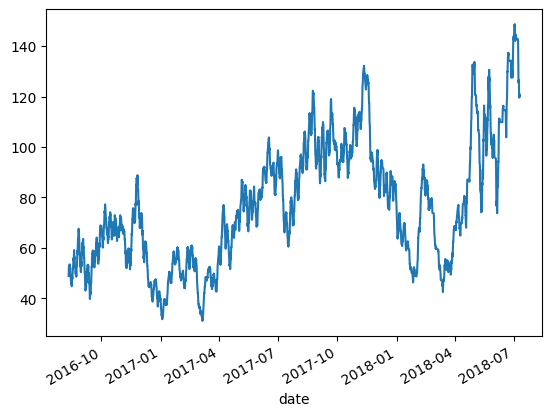

In [126]:
bicis_por_dia.rolling(240).mean().plot()

#### Observación:

* A partir de estos resultados, podemos ver que el test estadístico es negativo, lo que indica una fuerte evidencia en contra de la hipótesis nula, es decir en contra de que la serie sea no estacionaria.
* El p valor es casi cercano a cero y menor a 0.05, lo que nos sugiere también que la hipótesis nula puede rechazarse. O sea hay evidencia sólida para concluir que nuestra serie temporal es **estacionaria**.
* El estadístico está muy por debajo de todos los valores críticos, lo que respalda aun más el rechazo de la hipótesis nula.

● Entrega clase 6: A partir de las transformaciones propuestas ajustar distintos modelos (S)ARIMA. Extraer orden, parámetros, coeficientes numéricos y análisis de la bondad del modelo.

● Ajustar y predecir usando redes neuronales LSTM. Comparar con predicciones usando SARIMA y extraer conclusiones.
● Reailzar el análisis espectral de la serie original. Hallar las frecuencias principales y comparar con las componentes cíclica y estacional usando la descomposición.

In [91]:
from statsmodels.tsa.ar_model import AutoReg


In [166]:
# Step 5: Fit the AR Model
lag_order = 7  # Example lag order, you may adjust this
model = AutoReg(bicis_por_dia.resample('D').sum(), lags=lag_order).fit()
model

In [191]:
s=bicis_por_dia.resample('D').sum()

In [192]:
len(s)

708

<Axes: xlabel='date'>

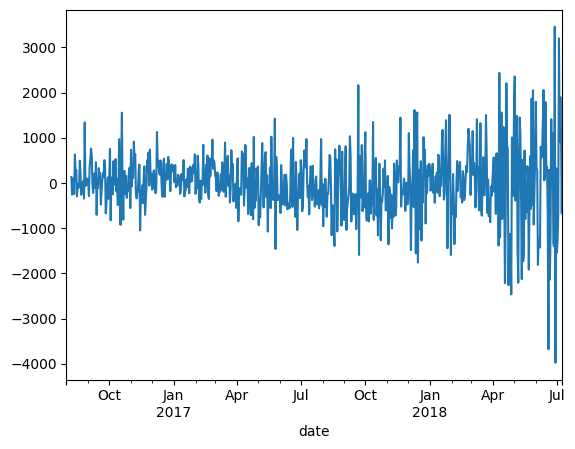

In [199]:
(model.predict() - s).plot()

<Axes: xlabel='date'>

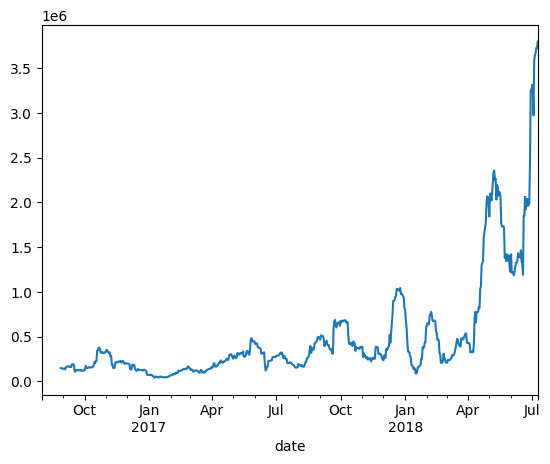

In [207]:
((model.predict() - s).rolling(21).std()**2).plot()

observamos que la varianza del error no es constante por lo que se rompe la assumption del test de dickey fuller de que el error debe ser white noise. 
Vamos a probartrimmeando desde abr 2018 y ver q pasa 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: xlabel='date'>

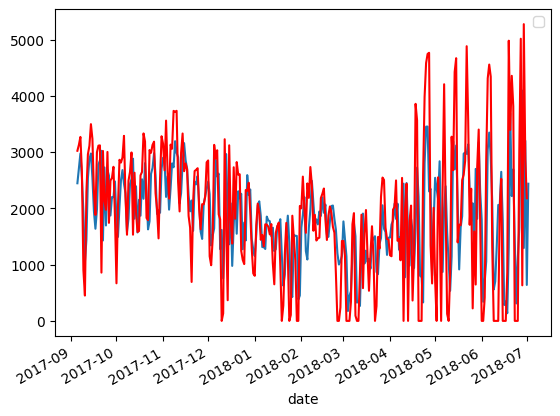

In [193]:
start=400
end=700
model.plot_predict(start=start, end=end)
s.iloc[start:end].plot(color='r')

# plt.legend(fig.a.get_lines(), ['data', 'model'])

In [214]:
pd.to_datetime('2016-08-01 00:00:00')
df_nofut = df_shorten[df_shorten['date'] <= pd.to_datetime('2018-04-01 23:59:59')].copy()
bicis_por_dia_nofut = df_nofut.groupby('date').bici_id_usuario.count().resample('D').sum()

In [215]:
bicis_por_dia_nofut

date
2016-08-01    1077
2016-08-02    1233
2016-08-03    1249
2016-08-04    1348
2016-08-05    1008
              ... 
2018-03-28    2505
2018-03-29    1657
2018-03-30    1455
2018-03-31    1442
2018-04-01    1165
Freq: D, Name: bici_id_usuario, Length: 609, dtype: int64

In [221]:
# Step 5: Fit the AR Model sin apr 2018 onwards
lag_order = 7  # Example lag order, you may adjust this
model = AutoReg(np.log(bicis_por_dia_nofut + 1), lags=lag_order).fit()
model

In [235]:
mask = bicis_por_dia_nofut > 0

In [246]:
np.percentile((err_raw[mask] / bicis_por_dia_nofut[mask]).dropna(), [25,50,75])

array([-0.15572087, -0.02502218,  0.23394316])

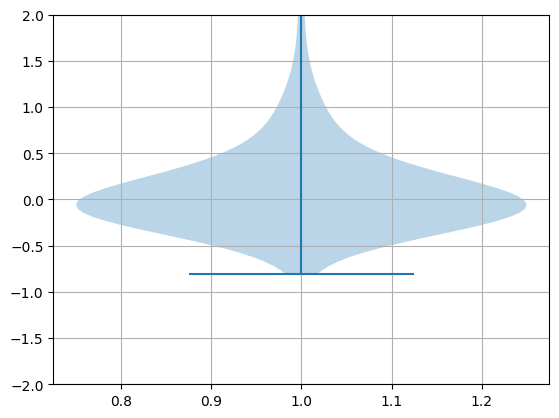

In [243]:
plt.violinplot((err_raw[mask] / bicis_por_dia_nofut[mask]).dropna(), points=300)
plt.ylim(-2,2)
plt.grid()

La mediana del error est'a en -0.02502218, lo que significa que el 50% de las veces predice alrededor de 2.5% menos que la data real. 
El 25% de las veces predice por defecto por lo menos un 15% menos que la data real.
El 25% de las veces predice por exceso al menos un 23% m'as que la data real. 


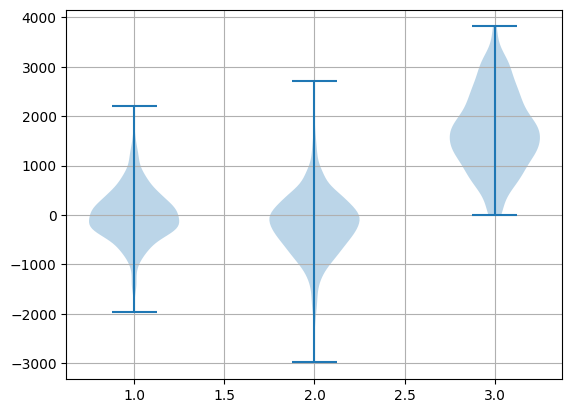

In [232]:
# ploteamos error
model = AutoReg(np.log(bicis_por_dia_nofut + 1), lags=lag_order).fit()

err_log = np.exp(model.predict())-1 - bicis_por_dia_nofut

# ploteamos error
model = AutoReg(bicis_por_dia_nofut, lags=lag_order).fit()

err_raw = model.predict() - bicis_por_dia_nofut

plt.violinplot([err_raw.dropna(), err_log.dropna(), bicis_por_dia_nofut.dropna()])

plt.grid()


plt.figure()
plt.violinplot([err_raw.dropna(), err_log.dropna(), bicis_por_dia_nofut.dropna()])

plt.grid()

Error tiene media cero que es menor que la media de la data.


<Axes: xlabel='date'>

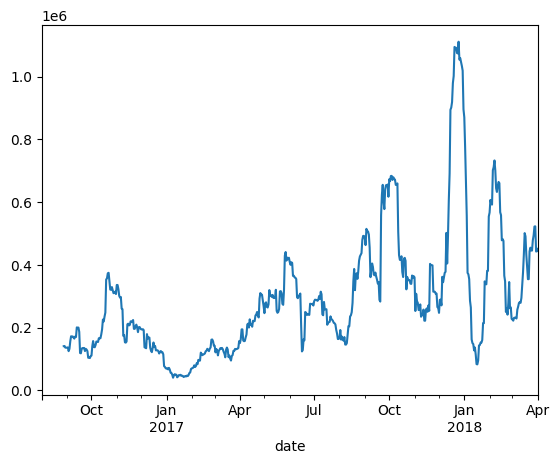

In [219]:
((model.predict() - bicis_por_dia_nofut).rolling(21).std()**2).plot()

In [261]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:        bici_id_usuario   No. Observations:                  609
Model:                     AutoReg(7)   Log Likelihood               -4637.217
Method:               Conditional MLE   S.D. of innovations            535.971
Date:                Fri, 05 Apr 2024   AIC                           9292.433
Time:                        22:11:56   BIC                           9332.036
Sample:                    08-08-2016   HQIC                          9307.847
                         - 04-01-2018                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                214.5656     69.659      3.080      0.002      78.037     351.094
bici_id_usuario.L1     0.5214      0.039     13.301      0.000       0.445       0.598
bici_id_usuario.L2    -0.1778      0.044     -4.025      0.000      -0.264      -0.091
bici_id_usuario.L3     0.0811      0.045      1.818      0.069      -0.006       0.169
bici_id_usuario.L4    -0.0609      0.045     -1.363      0.173      -0.148       0.027
bici_id_usuario.L5     0.0854      0.045      1.912      0.056      -0.002       0.173
bici_id_usuario.L6     0.1494      0.044      3.380      0.001       0.063       0.236
bici_id_usuario.L7     0.2766      0.039      7.052      0.000       0.200       0.353
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0335           -0.0000j            1.0335           -0.0000
AR.2            0.6777           -0.8490j            1.0863           -0.1428
AR.3            0.6777           +0.8490j            1.0863            0.1428
AR.4           -0.2625           -1.2163j            1.2443           -0.2838
AR.5           -0.2625           +1.2163j            1.2443            0.2838
AR.6           -1.2020           -0.6853j            1.3836           -0.4175
AR.7           -1.2020           +0.6853j            1.3836            0.4175
-----------------------------------------------------------------------------
"""

In [258]:
periodos = list(range(0,10))
p_values=[]

for i in periodos:
    bicis_diferenciada = bicis_por_dia_nofut.diff(periods=i).dropna() if i else bicis_por_dia_nofut
    adf_result = adfuller(bicis_diferenciada)[1]
    p_values.append(adf_result)
    

    

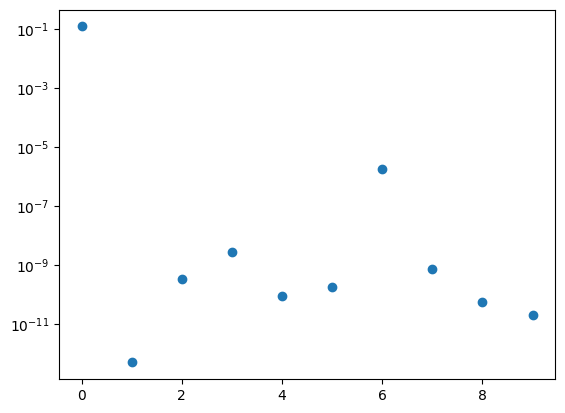

In [259]:
plt.scatter(periodos, p_values)
plt.yscale('log')

In [260]:
p_values

[0.11942608868223425,
 5.1034684881957e-13,
 3.4396241583273314e-10,
 2.7864512199131097e-09,
 9.066928096460961e-11,
 1.7616719080904544e-10,
 1.828397707299868e-06,
 7.363569467135108e-10,
 5.5177595865980803e-11,
 2.1011750547832714e-11]

Con una diferenciacion para hacer la serie estacionaria es suficiente un lag (o sea diferenciar una sola ez) porque son todos valores muy peque;os
SIN DIFERENCIACION VEMOS QUE EL p valor es 0,11 o sea uqe no podemos rechazar la hipotesis nula, por lo tanto NO ES ESTACIONARIA
solo recortando la parte desde abril en adelante.  porque rompia la hipotesis del error estacionario y el test daba un FP, daba significativo cuando no lo era. 

In [284]:
from statsmodels.tsa.arima.model import ARIMA


order = 7 
ma_model = ARIMA(bicis_por_dia_nofut, order=(0, 0, order)).fit()
ma_model.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        bici_id_usuario   No. Observations:                  609
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -4743.816
Date:                Fri, 05 Apr 2024   AIC                           9505.632
Time:                        23:29:25   BIC                           9545.338
Sample:                    08-01-2016   HQIC                          9521.079
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1679.7248     61.917     27.128      0.000    1558.369    1801.081
ma.L1          0.5673      0.035     16.111      0.000       0.498       0.636
ma.L2          0.1276      0.038      3.355      0.001       0.053       0.202
ma.L3          0.0848      0.041      2.065      0.039       0.004       0.165
ma.L4          0.0400      0.044      0.918      0.359      -0.045       0.125
ma.L5          0.1268      0.035      3.669      0.000       0.059       0.194
ma.L6          0.2799      0.042      6.641      0.000       0.197       0.362
ma.L7          0.3117      0.039      8.019      0.000       0.236       0.388
sigma2      3.409e+05   1.94e+04     17.544      0.000    3.03e+05    3.79e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.90   Jarque-Bera (JB):                10.60
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               2.62   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='date'>

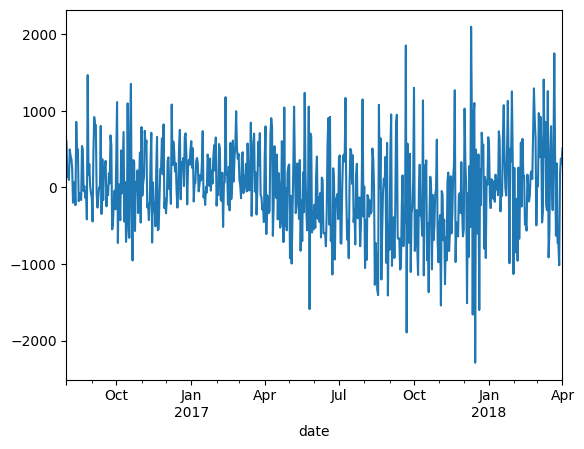

In [287]:
(ma_model.predict() - bicis_por_dia_nofut).plot()

<Axes: xlabel='date'>

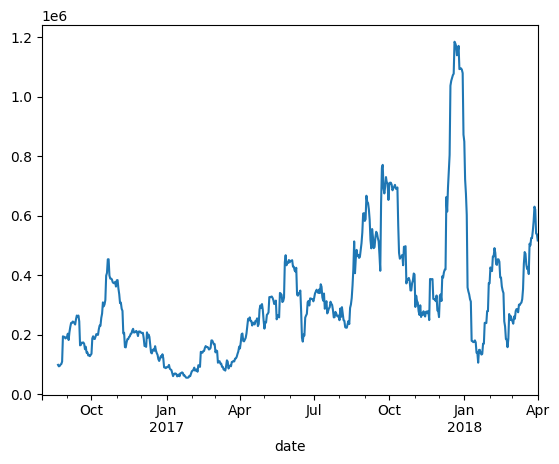

In [290]:
((ma_model.predict() - bicis_por_dia_nofut).rolling(21).std()**2).plot()

<Axes: xlabel='date'>

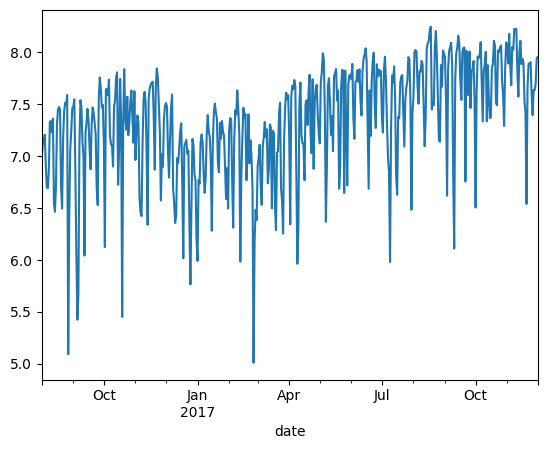

In [341]:
np.log(1+bicis_por_dia_nofut[:'2017-12-01']).plot()

In [ ]:
sm.tsa.ARIMA(np.log(df_accumulative+1), order=(7,1,7), ).fit()

In [356]:
bicis_por_dia_nofut[:'2017-12-01'].iloc[10:].sort_index()

date
2016-08-11    1378
2016-08-12    1573
2016-08-13     694
2016-08-14     641
2016-08-15     826
              ... 
2017-11-27    2074
2017-11-28    2071
2017-11-29    2203
2017-11-30    2818
2017-12-01    2851
Freq: D, Name: bici_id_usuario, Length: 478, dtype: int64

Arima


/Users/marianata/miniconda3/envs/obesity_risk/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/marianata/miniconda3/envs/obesity_risk/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/marianata/miniconda3/envs/obesity_risk/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


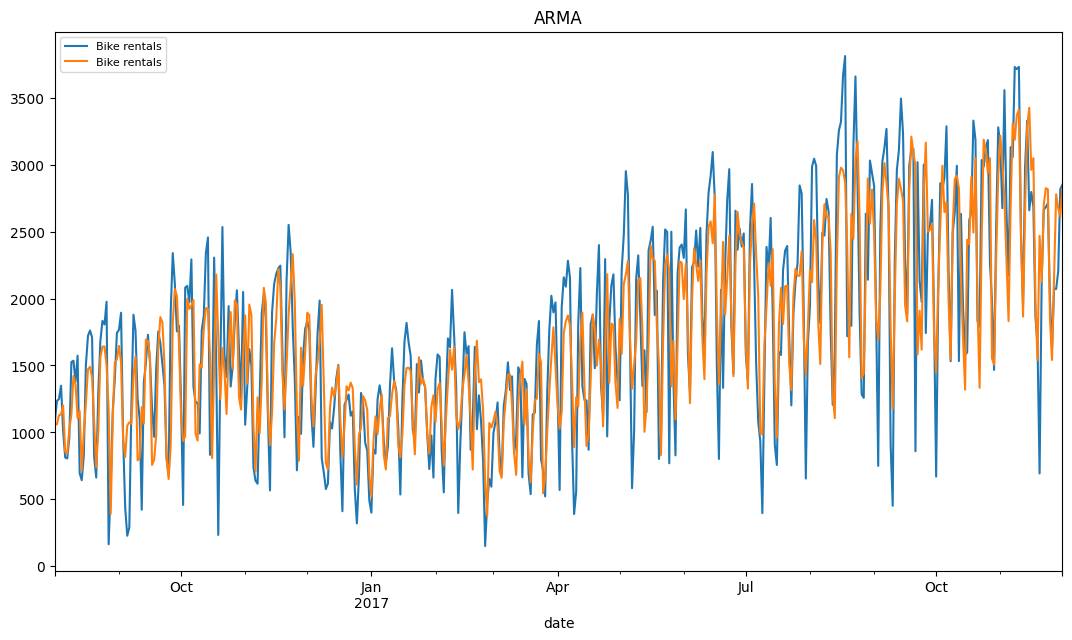

In [360]:
print("Arima")
def plotARMA(df_accumulative,ax,label):
    mod = sm.tsa.ARIMA(df_accumulative, order=(7,1,7), missing='raise').fit()
    df_accumulative.plot(ax=ax,label=label)
    mod.predict()[1:].plot(ax=ax,label=label)
    return mod

fig,ax = plt.subplots(figsize=(13,7))    
mod = plotARMA(bicis_por_dia_nofut[:'2017-12-01'],ax,"Bike rentals")
# mod = plotARMA(np.log(1+bicis_por_dia_nofut[:'2017-12-01']),ax,"Bike rentals")

plt.legend(fontsize=8)
plt.title("ARMA")
plt.show()


In [366]:
sm.tsa.SARIMAX?

Init signature:
sm.tsa.SARIMAX(
    endog,
    exog=None,
    order=(1, 0, 0),
    seasonal_order=(0, 0, 0, 0),
    trend=None,
    measurement_error=False,
    time_varying_regression=False,
    mle_regression=True,
    simple_differencing=False,
    enforce_stationarity=True,
    enforce_invertibility=True,
    hamilton_representation=False,
    concentrate_scale=False,
    trend_offset=1,
    use_exact_diffuse=False,
    dates=None,
    freq=None,
    missing='none',
    validate_specification=True,
    **kwargs,
)
Docstring:     
Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
model

Parameters
----------
endog : array_like
    The observed time-series process :math:`y`
exog : array_like, optional
    Array of exogenous regressors, shaped nobs x k.
order : iterable or iterable of iterables, optional
    The (p,d,q) order of the model for the number of AR parameters,
    differences, and MA parameters. `d` must be an integer
    indicating the integration

SArimax


/Users/marianata/miniconda3/envs/obesity_risk/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.45849D+00    |proj g|=  6.64064D-01


 This problem is unconstrained.



At iterate    5    f=  7.17020D+00    |proj g|=  8.93716D-02

At iterate   10    f=  7.15036D+00    |proj g|=  6.17532D-02

At iterate   15    f=  7.14599D+00    |proj g|=  1.67591D-02

At iterate   20    f=  7.14427D+00    |proj g|=  1.23524D-02

At iterate   25    f=  7.14352D+00    |proj g|=  2.05277D-02

At iterate   30    f=  7.14290D+00    |proj g|=  2.05668D-02

At iterate   35    f=  7.14270D+00    |proj g|=  1.72659D-02

At iterate   40    f=  7.14258D+00    |proj g|=  2.82936D-02

At iterate   45    f=  7.14243D+00    |proj g|=  9.07645D-03


/Users/marianata/miniconda3/envs/obesity_risk/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  7.14239D+00    |proj g|=  1.88282D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     54      1     0     0   1.883D-02   7.142D+00
  F =   7.1423906014471399     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


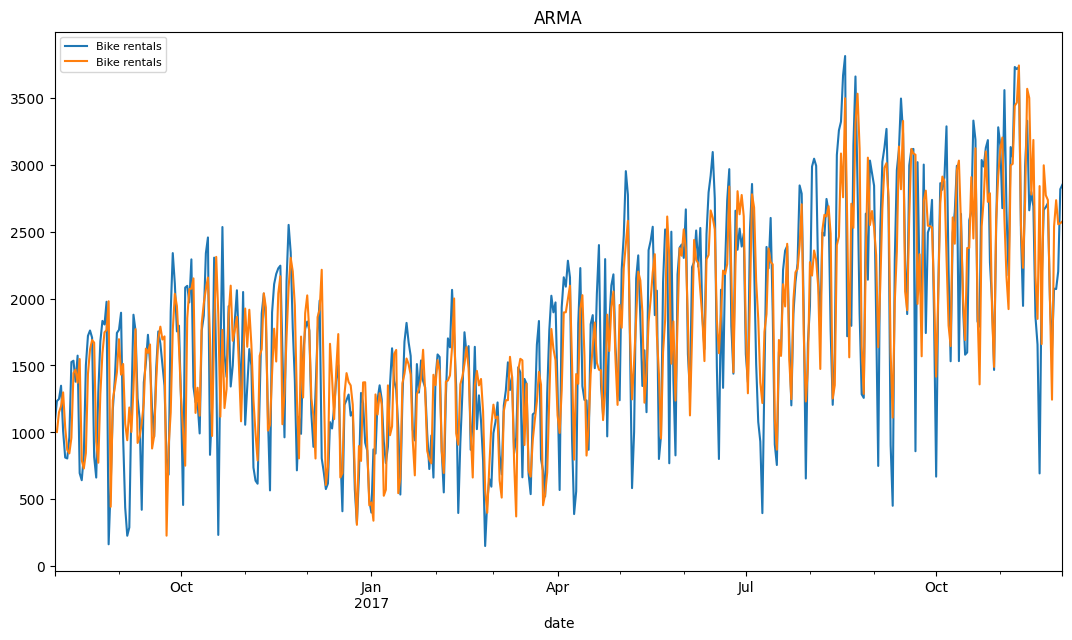

In [369]:
print("SArimax")
def plotARMA(df_accumulative,ax,label):
    mod = sm.tsa.SARIMAX(df_accumulative, order=(7,1,7), seasonal_order=(4,1,4,28), missing='raise').fit()
    df_accumulative.plot(ax=ax,label=label)
    mod.predict()[1:].plot(ax=ax,label=label)
    return mod

fig,ax = plt.subplots(figsize=(13,7))    
mod = plotARMA(bicis_por_dia_nofut[:'2017-12-01'],ax,"Bike rentals")
# mod = plotARMA(np.log(1+bicis_por_dia_nofut[:'2017-12-01']),ax,"Bike rentals")

plt.legend(fontsize=8)
plt.title("ARMA")
plt.show()


seasonal order 4 = 4 meses, s = 28 porque cada ciclo tiene 28 dias 

In [321]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        bici_id_usuario   No. Observations:                  609
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -4691.583
Date:                Sat, 06 Apr 2024   AIC                           9413.165
Time:                        00:10:21   BIC                           9479.318
Sample:                    08-01-2016   HQIC                          9438.902
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7828      2.992     -0.262      0.794      -6.648       5.082
ar.L2         -0.0864      0.961     -0.090      0.928      -1.971       1.798
ar.L3         -0.0143      0.177     -0.081      0.936      -0.362       0.333
ar.L4         -0.4975      0.186     -2.682      0.007      -0.861      -0.134
ar.L5         -0.6326      1.461     -0.433      0.665      -3.495       2.230
ar.L6          0.2626      1.264      0.208      0.835      -2.214       2.739
ar.L7          0.2200      1.331      0.165      0.869      -2.389       2.829
ma.L1          0.3464      3.021      0.115      0.909      -5.575       6.268
ma.L2         -0.6557      0.355     -1.847      0.065      -1.352       0.040
ma.L3         -0.5258      1.860     -0.283      0.777      -4.172       3.120
ma.L4          0.3647      0.710      0.514      0.607      -1.026       1.756
ma.L5          0.6027      1.509      0.399      0.690      -2.354       3.560
ma.L6         -0.5452      1.109     -0.492      0.623      -2.718       1.628
ma.L7         -0.3366      2.207     -0.153      0.879      -4.662       3.988
sigma2      2.696e+05   5.48e+04      4.922      0.000    1.62e+05    3.77e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                20.72
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               2.63   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [312]:
order = (7,1,7)
seasonal_order = (1,0,1,21)
sarima_model = sm.tsa.SARIMAX(bicis_por_dia_nofut, order=order, seasonal_order=seasonal_order).fit()
sarima_model.summary()



/Users/marianata/miniconda3/envs/obesity_risk/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49115D+01    |proj g|=  4.79367D+02

At iterate    5    f=  1.23770D+01    |proj g|=  2.54149D+01

At iterate   10    f=  8.57219D+00    |proj g|=  9.17979D+00

At iterate   15    f=  7.93337D+00    |proj g|=  4.07104D-01

At iterate   20    f=  7.78067D+00    |proj g|=  1.64396D-01

At iterate   25    f=  7.74716D+00    |proj g|=  3.53985D-01

At iterate   30    f=  7.71638D+00    |proj g|=  1.28873D+00

At iterate   35    f=  7.66071D+00    |proj g|=  3.98882D-01

At iterate   40    f=  7.64714D+00    |proj g|=  6.26316D-02

At iterate   45    f=  7.64221D+00    |proj g|=  9.85411D-01


/Users/marianata/miniconda3/envs/obesity_risk/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  7.64042D+00    |proj g|=  6.75144D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     61      1     0     0   6.751D-02   7.640D+00
  F =   7.6404215522065817     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      bici_id_usuario   No. Observations:                  609
Model:             SARIMAX(7, 1, 7)x(1, 0, [1], 21)   Log Likelihood               -4653.017
Date:                              Sat, 06 Apr 2024   AIC                           9340.033
Time:                                      00:02:12   BIC                           9415.006
Sample:                                  08-01-2016   HQIC                          9369.202
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5505      0.181     -3.042      0.002      -0.905      -0.196
ar.L2         -0.0823      0.148     -0.554      0.579      -0.373       0.209
ar.L3         -0.2314      0.142     -1.631      0.103      -0.509       0.047
ar.L4         -0.1200      0.109     -1.099      0.272      -0.334       0.094
ar.L5         -0.6819      0.099     -6.898      0.000      -0.876      -0.488
ar.L6         -0.1803      0.109     -1.649      0.099      -0.395       0.034
ar.L7          0.4082      0.088      4.639      0.000       0.236       0.581
ma.L1          0.1362      0.205      0.664      0.507      -0.266       0.538
ma.L2         -0.5208      0.409     -1.273      0.203      -1.323       0.281
ma.L3         -0.1604      0.382     -0.420      0.675      -0.909       0.588
ma.L4         -0.1656      0.359     -0.462      0.644      -0.869       0.538
ma.L5          0.6290      0.500      1.257      0.209      -0.352       1.610
ma.L6         -0.0608      0.139     -0.438      0.661      -0.333       0.211
ma.L7         -0.6894      0.299     -2.305      0.021      -1.276      -0.103
ar.S.L21       0.8045      0.065     12.287      0.000       0.676       0.933
ma.S.L21      -0.6059      0.101     -6.015      0.000      -0.803      -0.408
sigma2      2.696e+05   1.11e+05      2.425      0.015    5.17e+04    4.87e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.76   Jarque-Bera (JB):                73.05
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               2.63   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.89e+14. Standard errors may be unstable.
"""

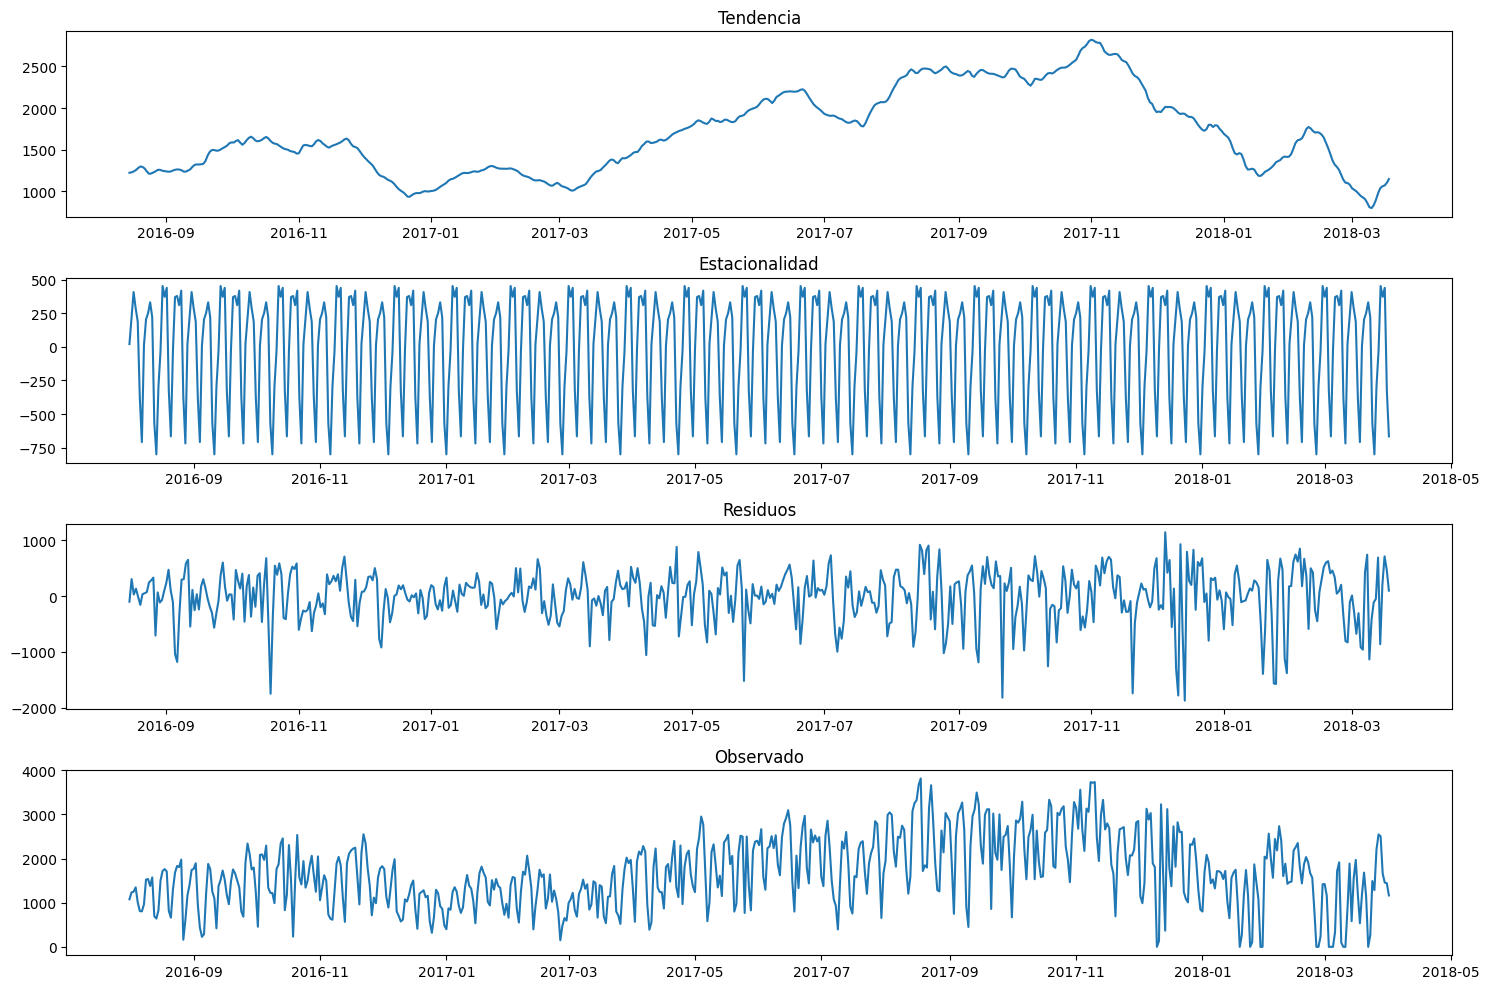

In [308]:
rents = df_nofut.set_index('date')
rents = rents.resample('D').bici_id_usuario.count()
daily_result = seasonal_decompose(rents, model='additive', period=28)

plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(daily_result.trend)
plt.title('Tendencia')

plt.subplot(4, 1, 2)
plt.plot(daily_result.seasonal)
plt.title('Estacionalidad')

plt.subplot(4, 1, 3)
plt.plot(daily_result.resid)
plt.title('Residuos')

plt.subplot(4, 1, 4)
plt.plot(daily_result.observed)
plt.title('Observado')

plt.tight_layout()
plt.show()

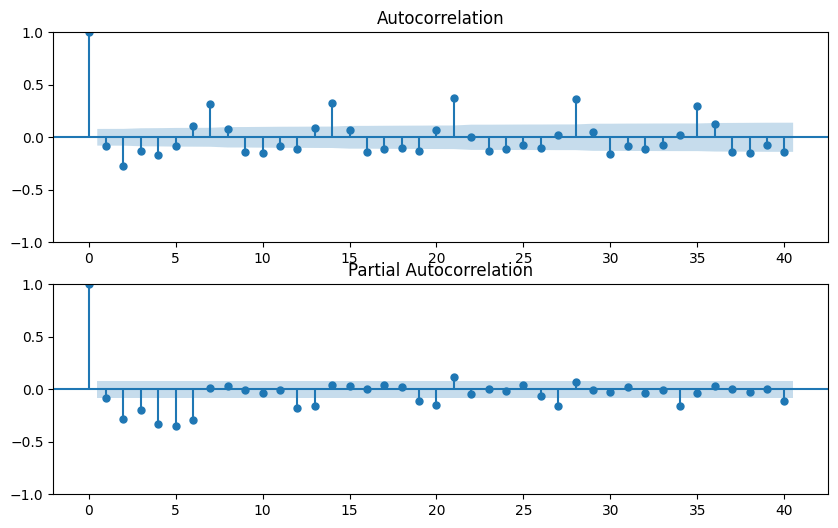

In [309]:
# Differencing to remove non-seasonal component
bicis_diff = bicis_por_dia_nofut.diff().dropna()

# Plot the ACF and PACF of the differenced time series
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(bicis_diff, lags=40, ax=axes[0])
plot_pacf(bicis_diff, lags=40, ax=axes[1])
plt.show()

In [ ]:
(1,0,1,7)

# SARIMA order parameters
p = ??  # Autoregressive order
d = ??  # Differencing order
q = ??  # Moving average order
P = ??  # Seasonal autoregressive order
D = ??  # Seasonal differencing order
Q = ??  # Seasonal moving average order
s = ??  # Seasonal period

# Fit SARIMA model
sarima_model = sm.tsa.SARIMAX(daily_rentals, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_results = sarima_model.fit()


In [69]:
weekly = df_shorten.bici_id_usuario

In [77]:
weekly

0           15728
1           26531
2          161323
3          239148
4          260323
            ...  
1457504    237401
1457505    235437
1457506    234242
1457507    243609
1457508    241629
Name: bici_id_usuario, Length: 1214393, dtype: int64

In [84]:
interval = 2

# Obtain the subsample by selecting every nth row
weekly_subsample = weekly.iloc[::interval]

In [85]:
weekly_subsample

0           15728
2          161323
4          260323
6          258213
8          262302
            ...  
1457500    229330
1457502    238601
1457504    237401
1457506    234242
1457508    241629
Name: bici_id_usuario, Length: 607197, dtype: int64

/Users/marianata/miniconda3/envs/obesity_risk/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marianata/miniconda3/envs/obesity_risk/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.03564D+00    |proj g|=  9.76996D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   9.770D-10   6.036D+00
  F =   6.0356387374263569     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                               SARIMAX Results                                
Dep. Variable:        bici_id_usuario   No. Observations:                15968
Model:                        SARIMA

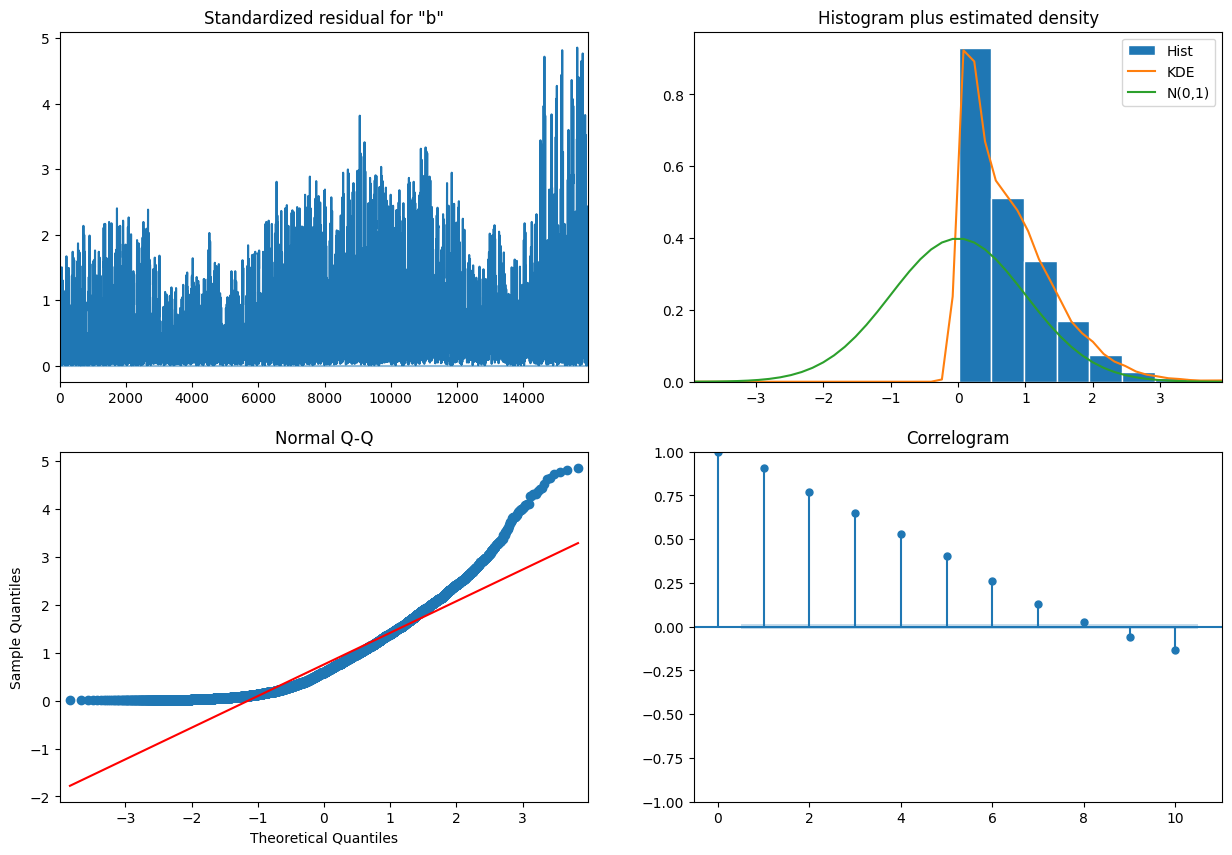

In [120]:
order = (0, 0, 0)            # Non-seasonal order parameters (p, d, q)
seasonal_order = (0, 0, 0, 7) # Seasonal order parameters (P, D, Q, s)

# Step 4: Fit the SARIMA model
sarima_model = sm.tsa.SARIMAX(bicis_por_dia, order=order, seasonal_order=seasonal_order)
sarima_results = sarima_model.fit()

# Step 5: Evaluate the model
print(sarima_results.summary())
sarima_results.plot_diagnostics(figsize=(15, 10))
plt.show()


AttributeError: 'PredictionResults' object has no attribute 'index'

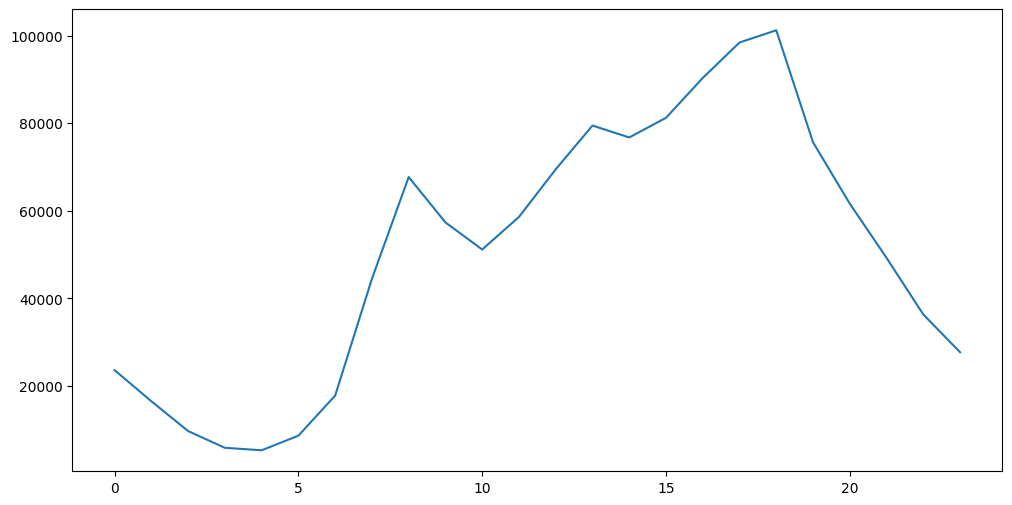

In [46]:
# Modelo Sarima 
# orden, parametros, coeficientes numericos, analisis deb ondad 
# arma, arima (modelos estacionarios)

# Forecasting
forecast = sarima_results.get_forecast(steps=2)
confidence_intervals = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(hourly_rentals.index, hourly_rentals, label='Actual')
plt.plot(forecast.index, forecast.predicted_mean, color='red', label='Forecast')
plt.fill_between(forecast.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.title('SARIMA Forecast for Hourly Bike Rentals')
plt.legend()
plt.show()


